# Experiment ONet
#### Setup:
**Dataset**: 3 different types of brain tumors <br>
**Loss function**: Dice loss <br>
**Optimizer**: Adam <br>
**Model**: ONet

In [1]:
# Imports and training parameters
import torch
from torchvision.transforms import transforms
from src.datasets import BrainTumorDatasetMaskAndBoundingBox
from src.loss import  dice_loss
from src.metrics import dice_coeff
from src.models import ONet
from src.trainers import Trainer
torch.manual_seed(0)

num_epochs = 100
batch_size = 2
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Data preparation
# load the data see data_preprocessing notebook for more explanation

def normalize(x,  mean=470, std=None):
    mean_tansor = torch.ones_like(x) * mean
    x -= mean_tansor
    if std:
        x /= std
    return x

def preprocessing(image, mask, bounding_box):
    mask_transformer = transforms.Compose([
        transforms.ToTensor()    
    ])
    mask_tensor = mask_transformer(mask).float()
    bounding_box_tensor = torch.zeros_like(mask_tensor).squeeze()
    bounding_box_tensor[bounding_box[0]:bounding_box[1],
                      bounding_box[2]:bounding_box[3]] = 1
    bounding_box_tensor = bounding_box_tensor.unsqueeze(0)
    image_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: normalize(x))
    ])
    return (image_transformer(image).float(), bounding_box_tensor), mask_tensor

target_folder = './data/'
ds_train = BrainTumorDatasetMaskAndBoundingBox(root=target_folder, train=True, transform=preprocessing)
ds_test = BrainTumorDatasetMaskAndBoundingBox(root=target_folder, train=False, transform=preprocessing)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=False)


Data directory already exists.  if from some reason the data directory structure is wrong please remove the data dir and rerun this script
Data directory already exists.  if from some reason the data directory structure is wrong please remove the data dir and rerun this script


In [3]:
# Training and evaluation
model = ONet()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = dice_loss
success_metric = dice_coeff
trainer = Trainer(model, criterion, optimizer, dice_coeff, device, None)
fit_res = trainer.fit(dl_train, 
                      dl_test,
                      num_epochs= num_epochs,
                      checkpoints='src/saved_models/' + model.__class__.__name__ + "with_reg")

--- EPOCH 1/100 ---
train_batch (Avg. Loss 0.828, Min 0.306, Max 1.000), (Avg. Score 0.1785, Min 0.0000, Max 0.7340): 100%|██████████| 1296/1296 [09:50<00:00,  2.18it/s]
test_batch (Avg. Loss 0.827, Min 0.425, Max 1.000), (Avg. Score 0.1869, Min 0.0000, Max 0.6647): 100%|██████████| 229/229 [00:38<00:00,  6.37it/s]
--- EPOCH 2/100 ---
train_batch (Avg. Loss 0.724, Min 0.203, Max 1.000), (Avg. Score 0.2791, Min 0.0000, Max 0.8234): 100%|██████████| 1296/1296 [09:51<00:00,  2.19it/s]
test_batch (Avg. Loss 0.819, Min 0.386, Max 1.000), (Avg. Score 0.1829, Min 0.0000, Max 0.6182): 100%|██████████| 229/229 [00:39<00:00,  5.83it/s]
--- EPOCH 3/100 ---
train_batch (Avg. Loss 0.649, Min 0.122, Max 1.000), (Avg. Score 0.3517, Min 0.0000, Max 0.8788): 100%|██████████| 1296/1296 [09:52<00:00,  2.20it/s]
test_batch (Avg. Loss 0.740, Min 0.118, Max 1.000), (Avg. Score 0.2631, Min 0.0000, Max 0.8817): 100%|██████████| 229/229 [00:39<00:00,  5.86it/s]
**** Checkpoint saved ****
--- EPOCH 4/100 ---
tr

(<Figure size 1152x720 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9394423690>,
       dtype=object))

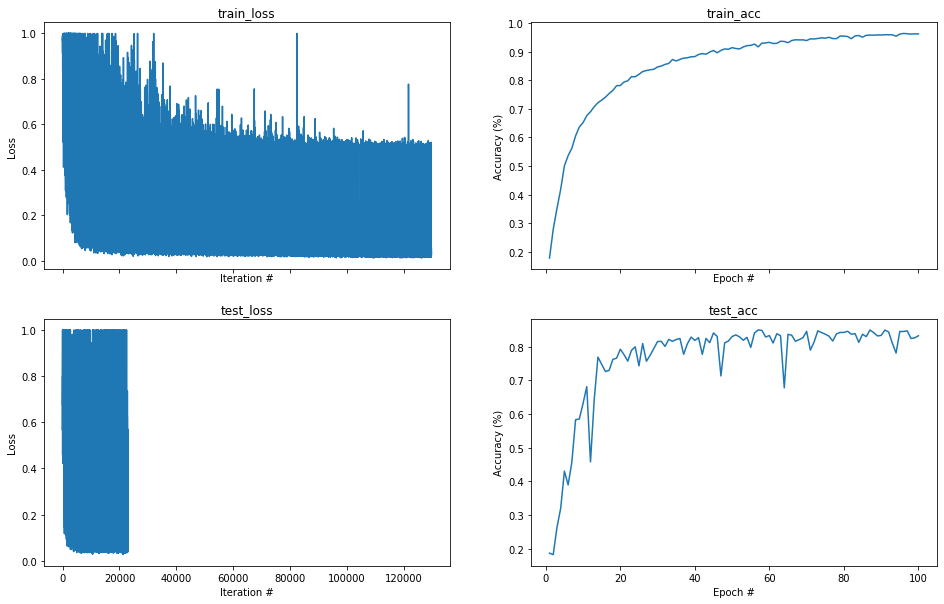

In [5]:
from cs236605.plot import plot_fit
plot_fit(fit_res)

In [6]:
print("Best dice score: %.2f" % fit_res.best_score)

Best dice score: 0.85


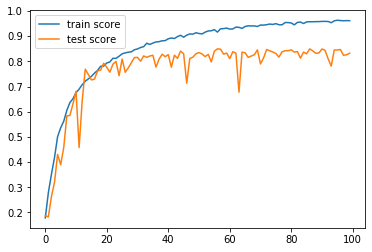

In [7]:
import matplotlib.pyplot as plt
plt.plot(fit_res.train_acc)
plt.plot(fit_res.test_acc)
plt.legend(['train score', 'test score'])
plt.show()